# In this notebook we will generate predictive model to forecast investments between Startups and Investors 

In [1]:
# import packges
import re
import shap
import random
import numpy as np
import pandas as pd 
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Read data after all preprocess and split to train and test

In [2]:
# read data 
rawdata = pd.read_csv('projects/data_files/inv_su_raw.csv', index_col = 0)

#split data into test and train
train, test = train_test_split(rawdata, test_size = 0.25, random_state  = 0, stratify = rawdata['inv_flag'])
train_x, train_y = train[train.columns.difference(['inv_flag'])], train['inv_flag']
test_x, test_y = test[test.columns.difference(['inv_flag'])], test['inv_flag']

C:\Users\orimo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5,6,7,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,29,31,32,33,34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data is extreamly imbalanced therefore - apply SMOT

In [3]:
# initial proportion
prop =  (train_y.value_counts()[1] / (train_y.value_counts()[0] + train_y.value_counts()[1])) * 100
print('Initial proportion of positive:  {prop}'.format(prop = "%.3f" % prop) + '%')

# apply SMOT
smt = SMOTE()
train_x, train_y = smt.fit_sample(train_x.select_dtypes([np.number]), train_y)
train_x = pd.DataFrame(train_x, columns = rawdata.select_dtypes([np.number]).columns.difference(['inv_flag']))

# proportion after SMOT
prop = (np.bincount(train_y)[1] / (np.bincount(train_y)[0] + np.bincount(train_y)[1])) * 100
print('After SMOT proportion of positive:  {prop}'.format(prop = "%.3f" % prop) + '%')


Initial proportion of positive:  0.261%
After SMOT proportion of positive:  50.000%


# Tune Hyper-parameters

In [4]:
# Find optimal hyperparameters for XGB clf
def select_xgb_clf(X, y, rounds = 100, nfold = 3, num_boost_round = 50, early_stopping_rounds = 10, seed = 0, objective = 'binary:logistic', eval_metric = 'logloss'):
    '''
    This function finds xgboost best calssifier hyperparameters.
    Best hyperparameters is seek by using random search and cross validation teqenques.
    @param X - matrix of features values
    @param y - target variable
    @param rounds - amount of random searhes for hyperparameters 
    @param nfold - number of folders in the cross validation process
    @param num_boost_round 
    @param early_stopping_rounds  
    @param seed 
    @param objective  
    @param eval_metric  
    @return param - dictionary which contain the best values achived during the search
    '''
    # adjustmnents to dataset:
    dmatrix = xgb.DMatrix(data = X, label = y)
    
    # hold best result
    score = {
        'params': None,
        'best_score': np.inf
    }
    
    # evaluate clf in each iteration
    for round_ in range(rounds):
        # parameters range space
        params = {'objective': objective,
                  'eval_metric': eval_metric,
                  'colsample_bytree': random.uniform(0.5, 0.8),             # Subsample ratio of columns when constructing each tree
                  'subsample': random.uniform(0.5, 0.8),                    # Subsample ratio of the training instance
                  'learning_rate': random.uniform(0.2, 0.5),                # Boosting learning rate 
                  'max_depth': random.randint(0, 9),                        # Maximum tree depth for base learners
                  'gamma': random.uniform(0.1, 0.3),                        # Minimum loss reduction required to make a further partition on a leaf node of the tree
                  'n_estimators': random.choice([100, 150, 200, 300, 500])  # Number of boosted trees to fit
        }
        
        # get evaluattion for the parameters using cross validation
        cv_results = xgb.cv(dtrain = dmatrix, params = params, nfold = nfold,
                            num_boost_round = num_boost_round, early_stopping_rounds = early_stopping_rounds,
                            metrics = eval_metric, seed = seed, as_pandas = False)
        
        # set param as best param if score is better
        mean_logloss = np.mean(cv_results['test-logloss-mean'])
        score['params'] = params if score['best_score'] > mean_logloss else score['params']
        
    return score['params']


# perform random search for hyper parameters 
params = select_xgb_clf(train_x, train_y, rounds = 100)
params


{'objective': 'binary:logistic',
 'eval_metric': 'logloss',
 'colsample_bytree': 0.6293491770520149,
 'subsample': 0.7535671181303909,
 'learning_rate': 0.3930958460869426,
 'max_depth': 3,
 'gamma': 0.12972274471081433,
 'n_estimators': 150}

# Generate XGB classifier

In [5]:
# Generate XGB classifier
xgb_clf = xgb.XGBClassifier(max_depth = params['max_depth'], 
                            learning_rate = params['learning_rate'],
                            n_estimators = params['n_estimators'], 
                            objective = params['objective'],
                            gamma = params['gamma'], 
                            subsample = params['subsample'], 
                            colsample_bytree = params['colsample_bytree'],
                            eval_metric = params['eval_metric'])

xgb_clf.fit(train_x, train_y) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6293491770520149,
       eval_metric='logloss', gamma=0.12972274471081433,
       learning_rate=0.3930958460869426, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.7535671181303909, verbosity=1)

# Predict investment and Rank fittness

In [6]:
# execute prediction
target_pred = xgb_clf.predict(test_x.select_dtypes([np.number]))
target_prob = xgb_clf.predict_proba(test_x.select_dtypes([np.number]))


# Evaluate Classifier

In [11]:
# confusion matrix
confusion = pd.crosstab(test_y, target_pred)

# report
print(classification_report(test_y, target_pred), '\n')
print(confusion)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16067
           1       0.41      0.74      0.53        42

   micro avg       1.00      1.00      1.00     16109
   macro avg       0.71      0.87      0.76     16109
weighted avg       1.00      1.00      1.00     16109
 

col_0         0   1
inv_flag           
0         16023  44
1            11  31


# Feature importence - Anova 

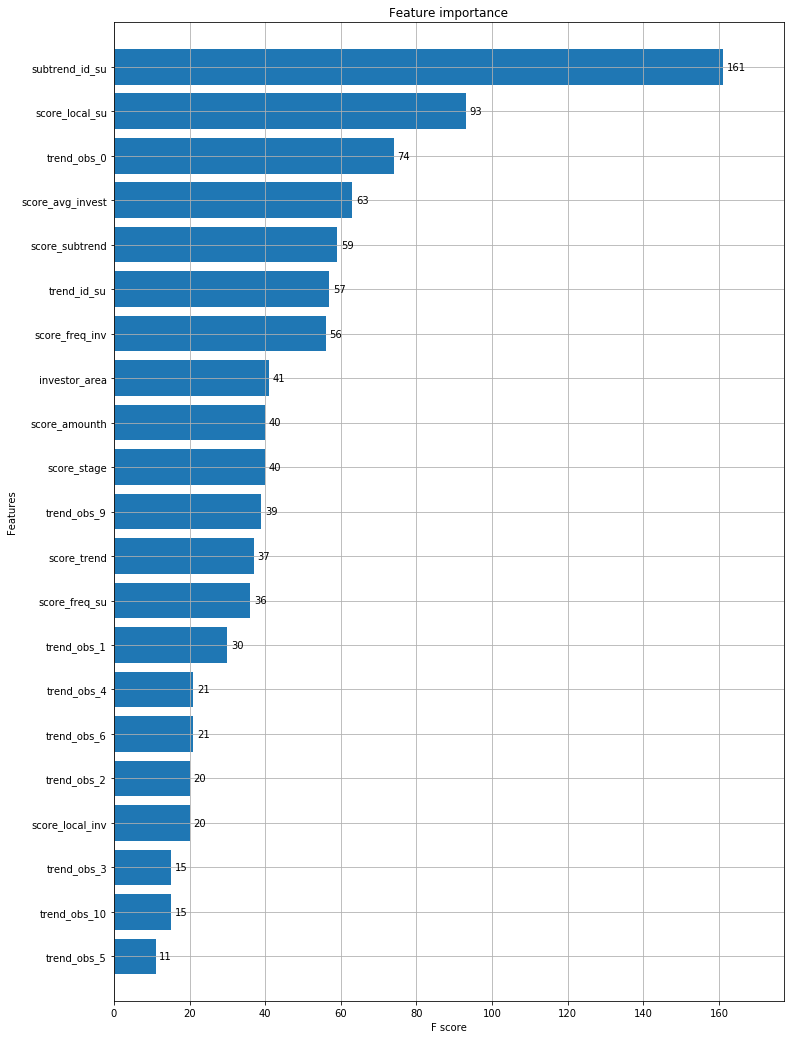

In [8]:
# Feature importence drawing
fig, ax = plt.subplots(figsize=(12,18))
xgb_clf.feature_names = rawdata.select_dtypes([np.number]).columns.difference(['inv_flag'])
xgb.plot_importance(xgb_clf, max_num_features = 50, height = 0.8, ax = ax)
plt.show()

# Shap - examine the value of feature on the class prediction

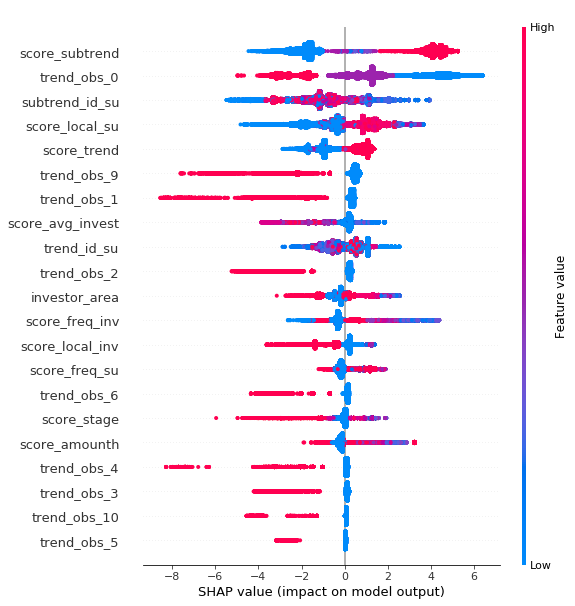

In [9]:
shap_values = shap.TreeExplainer(xgb_clf).shap_values(train_x)
shap.summary_plot(shap_values, train_x, max_display = 30)

# Rank potential investments 

In [10]:
id_ = [inv for inv in test_x['identify'] if bool(re.match(r'^950.*', inv))]
test_x['prob'] = target_prob[:,1]
rank = test_x[['identify', 'prob']][test_x.identify.isin(id_)].sort_values(by = ['prob'], ascending = False)
rank.head(10)

,identify,prob
45383,950_208,0.217789
45471,950_373,0.155932
45426,950_280,0.155932
45617,950_51,0.155932
45420,950_250,0.155932
45338,950_148,0.155932
45380,950_204,0.155932
45448,950_345,0.155932
45369,950_188,0.138713
45405,950_233,0.070884
